# Introduction

Do higher film budgets lead to more box office revenue? Let's find out if there's a relationship using the movie budgets and financial performance data that I've scraped from [the-numbers.com](https://www.the-numbers.com/movie/budgets) on **April 14th, 2023**. 

<img src=https://i.imgur.com/kq7hrEh.png>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Statements

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Notebook Presentation

In [ ]:
pd.options.display.float_format = '{:,.2f}'.format

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Read the Data

In [ ]:
file_path = '/content/drive/MyDrive/Colab Notebooks/Film Budgets and Box Office Revenues/cost_revenue_dirty.csv'
data = pd.read_csv(file_path)

# Data Cleaning and Modification

We see that the data has no NaN values and zero duplicates.

In [ ]:
data.shape

(6383, 6)

In [ ]:
data.isna().sum()

Rank                     0
Release_Date             0
Movie_Title              0
USD_Production_Budget    0
USD_Domestic_Gross       0
USD_Worldwide_Gross      0
dtype: int64

In [ ]:
data.duplicated().values.any()

False

### Data Type Conversions

In [ ]:
data

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Domestic_Gross,USD_Worldwide_Gross
0,1,"Dec 9, 2022",Avatar: The Way of Water,"$460,000,000","$682,790,957","$2,314,826,263"
1,2,"Apr 23, 2019",Avengers: Endgame,"$400,000,000","$858,373,000","$2,794,731,755"
2,3,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$379,000,000","$241,071,802","$1,045,713,802"
3,4,"Apr 22, 2015",Avengers: Age of Ultron,"$365,000,000","$459,005,868","$1,395,316,979"
4,5,"May 17, 2023",Fast X,"$340,000,000",$0,$0
...,...,...,...,...,...,...
6378,"6,379","Apr 2, 1999",Following,"$6,000","$48,482","$240,495"
6379,"6,380","Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338"
6380,"6,381","Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0
6381,"6,382","Aug 5, 2005",My Date With Drew,"$1,100","$181,041","$181,041"


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6383 entries, 0 to 6382
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Rank                   6383 non-null   object
 1   Release_Date           6383 non-null   object
 2   Movie_Title            6383 non-null   object
 3   USD_Production_Budget  6383 non-null   object
 4   USD_Domestic_Gross     6383 non-null   object
 5   USD_Worldwide_Gross    6383 non-null   object
dtypes: object(6)
memory usage: 299.3+ KB


Note the presence of films that gross \$0. To further analyze and clean $0 revenue films, we must first convert `Release_Date`, `USD_Production_Budget`, `USD_Worldwide_Gross` and `USD_Domestic_Gross` columns from object dtype, i.e. strings, into datetime and floats respectively.

In [ ]:
# several films have different invalid formats
valid_value_flag = []
for date in data['Release_Date']:
  try:
    pd.to_datetime(date, format='%b %d, %Y')
  except ValueError:
    valid_value_flag.append(False)
  else: 
    valid_value_flag.append(True)

In [ ]:
data_clean = data[valid_value_flag]
data_clean.head()

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Domestic_Gross,USD_Worldwide_Gross
0,1,"Dec 9, 2022",Avatar: The Way of Water,"$460,000,000","$682,790,957","$2,314,826,263"
1,2,"Apr 23, 2019",Avengers: Endgame,"$400,000,000","$858,373,000","$2,794,731,755"
2,3,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$379,000,000","$241,071,802","$1,045,713,802"
3,4,"Apr 22, 2015",Avengers: Age of Ultron,"$365,000,000","$459,005,868","$1,395,316,979"
4,5,"May 17, 2023",Fast X,"$340,000,000",$0,$0


In [ ]:
culled_rows = data.shape[0] - data_clean.shape[0]
print(f'{culled_rows} entries had invalid release dates and were removed, leaving {data_clean.shape[0]} movies remaining.')

146 entries had invalid release dates and were removed, leaving 6237 movies remaining.


In [ ]:
data_clean.loc[:, 'Release_Date'] = pd.to_datetime(data_clean['Release_Date'], format='%b %d, %Y')

<ipython-input-13-90db50adad14>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean.loc[:, 'Release_Date'] = pd.to_datetime(data_clean['Release_Date'], format='%b %d, %Y')
<ipython-input-13-90db50adad14>:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_clean.loc[:, 'Release_Date'] = pd.to_datetime(data_clean['Release_Date'], format='%b %d, %Y')


In [ ]:
columns = ['USD_Domestic_Gross', 'USD_Worldwide_Gross', 'USD_Production_Budget']
chars_to_remove = [',', '\$|', '']  # extra escape characters for regex

In [ ]:
data_clean.loc[:, columns] = data_clean[columns].replace(chars_to_remove, value='', regex=True).astype(float)

<ipython-input-15-b8a883a7a163>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean.loc[:, columns] = data_clean[columns].replace(chars_to_remove, value='', regex=True).astype(float)
<ipython-input-15-b8a883a7a163>:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_clean.loc[:, columns] = data_clean[columns].replace(chars_to_remove, value='', regex=True).astype(float)


In [ ]:
data_clean.dtypes

Rank                             object
Release_Date             datetime64[ns]
Movie_Title                      object
USD_Production_Budget           float64
USD_Domestic_Gross              float64
USD_Worldwide_Gross             float64
dtype: object

In [ ]:
data_clean.head()

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Domestic_Gross,USD_Worldwide_Gross
0,1,2022-12-09,Avatar: The Way of Water,"460,000,000.00","682,790,957.00","2,314,826,263.00"
1,2,2019-04-23,Avengers: Endgame,"400,000,000.00","858,373,000.00","2,794,731,755.00"
2,3,2011-05-20,Pirates of the Caribbean: On Stranger Tides,"379,000,000.00","241,071,802.00","1,045,713,802.00"
3,4,2015-04-22,Avengers: Age of Ultron,"365,000,000.00","459,005,868.00","1,395,316,979.00"
4,5,2023-05-17,Fast X,"340,000,000.00",0.00,0.00


### Unreleased Films

The dataset contains movies that are either too recent or have not been released yet. 

In [ ]:
# Date of Data Collection: 4/14/2023
# Subtract 2 months to filter out most recent movies that do not have stable revenues
cutoff_date = pd.Timestamp('2023-2-14')

In [ ]:
new_releases = data_clean[data_clean.Release_Date >= cutoff_date]
print(f'{new_releases.shape[0]} entries are either movies that are too recent or have not been release yet.')

17 entries are either movies that are too recent or have not been release yet.


In [ ]:
data_clean.drop(index=new_releases.index, inplace=True)

<ipython-input-20-3bd47b3d05e0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean.drop(index=new_releases.index, inplace=True)


In [ ]:
print(f'There are now {data_clean.shape[0]} movies in the dataset.')

There are now 6220 movies in the dataset.


### Investigating the Zero Revenue Films

How many films grossed $0 domestically? What were the highest budget films that grossed nothing?

In [ ]:
data_clean[data_clean['USD_Domestic_Gross'] == 0].sort_values('USD_Production_Budget', ascending=False).head()

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Domestic_Gross,USD_Worldwide_Gross
88,89,2020-09-04,Mulan,"200,000,000.00",0.00,"69,973,540.00"
90,91,2022-07-13,The Gray Man,"200,000,000.00",0.00,"451,178.00"
89,90,2021-07-02,The Tomorrow War,"200,000,000.00",0.00,"19,220,000.00"
145,146,2022-03-10,Turning Red,"175,000,000.00",0.00,"10,964,971.00"
184,185,2019-11-01,The Irishman,"159,000,000.00",0.00,"914,706.00"


In [ ]:
zero_world = data_clean[data_clean['USD_Worldwide_Gross'] == 0].count()[0]
zero_dom = data_clean[data_clean['USD_Domestic_Gross'] == 0].count()[0]
print(f'{zero_dom} movies grossed $0 domestically and {zero_world} grossed $0 worldwide.')

582 movies grossed $0 domestically and 325 grossed $0 worldwide.


Here are the 5 highest budget films that grossed $0 worldwide.

In [ ]:
data_clean.query('USD_Worldwide_Gross == 0').sort_values('USD_Production_Budget', ascending=False).head()

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Domestic_Gross,USD_Worldwide_Gross
242,243,2019-12-13,6 Underground,"150,000,000.00",0.00,0.00
356,357,2018-11-09,Outlaw King,"120,000,000.00",0.00,0.00
357,358,2022-12-02,Emancipation,"120,000,000.00",0.00,0.00
369,370,2019-03-06,Triple Frontier,"115,000,000.00",0.00,0.00
477,478,2020-06-12,Artemis Fowl,"100,000,000.00",0.00,0.00


### Adding Film Profits

In [ ]:
data_clean['Profit'] = data_clean.USD_Worldwide_Gross.subtract(data_clean.USD_Production_Budget)

<ipython-input-25-5375bb4a48dd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['Profit'] = data_clean.USD_Worldwide_Gross.subtract(data_clean.USD_Production_Budget)


In [ ]:
data_clean.head()

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Domestic_Gross,USD_Worldwide_Gross,Profit
0,1,2022-12-09,Avatar: The Way of Water,"460,000,000.00","682,790,957.00","2,314,826,263.00","1,854,826,263.00"
1,2,2019-04-23,Avengers: Endgame,"400,000,000.00","858,373,000.00","2,794,731,755.00","2,394,731,755.00"
2,3,2011-05-20,Pirates of the Caribbean: On Stranger Tides,"379,000,000.00","241,071,802.00","1,045,713,802.00","666,713,802.00"
3,4,2015-04-22,Avengers: Age of Ultron,"365,000,000.00","459,005,868.00","1,395,316,979.00","1,030,316,979.00"
5,6,2015-12-16,Star Wars Ep. VII: The Force Awakens,"306,000,000.00","936,662,225.00","2,064,615,817.00","1,758,615,817.00"


# Descriptive Statistics

**Challenge**: 

1. What is the average production budget of the films in the data set?
2. What is the average worldwide gross revenue of films?
3. What were the minimums for worldwide and domestic revenue?
4. Are the bottom 25% of films actually profitable or do they lose money?
5. What are the highest production budget and highest worldwide gross revenue of any film?
6. How much revenue did the lowest and highest budget films make?

In [ ]:
desired_stats = ['count', 'mean', 'min', '50%', 'max']

In [ ]:
data_clean.describe().loc[desired_stats]

,USD_Production_Budget,USD_Domestic_Gross,USD_Worldwide_Gross,Profit
count,"6,220.00","6,220.00","6,220.00","6,220.00"
mean,"32,564,678.38","42,440,499.20","94,236,450.33","61,671,771.95"
min,86.00,0.00,0.00,"-199,548,822.00"
50%,"17,000,000.00","17,048,554.50","28,676,319.50","8,733,738.00"
max,"460,000,000.00","936,662,225.00","2,923,706,026.00","2,686,706,026.00"


### Profitable and Nonprofitable Films

In [ ]:
negative_films = data_clean.query('Profit < 0')
print(f'Percentage of films that lost money: {negative_films.shape[0]/data_clean.shape[0]*100:.1f}%')

Percentage of films that lost money: 36.5%


In [ ]:
negative_films.describe().loc[desired_stats]

,USD_Production_Budget,USD_Domestic_Gross,USD_Worldwide_Gross,Profit
count,"2,273.00","2,273.00","2,273.00","2,273.00"
mean,"21,244,162.48","6,337,051.03","10,299,443.34","-10,944,719.14"
min,86.00,0.00,0.00,"-199,548,822.00"
50%,"12,000,000.00","657,511.00","2,013,340.00","-5,396,999.00"
max,"200,000,000.00","100,289,690.00","174,131,329.00",-86.00


In [ ]:
profitable_films = data_clean.query('USD_Worldwide_Gross > USD_Production_Budget')
profitable_films.describe().loc[desired_stats]

,USD_Production_Budget,USD_Domestic_Gross,USD_Worldwide_Gross,Profit
count,"3,947.00","3,947.00","3,947.00","3,947.00"
mean,"39,083,941.77","63,231,767.93","142,574,128.79","103,490,187.01"
min,"1,100.00",0.00,"48,363.00",349.00
50%,"20,000,000.00","37,800,000.00","67,029,956.00","37,977,250.00"
max,"460,000,000.00","936,662,225.00","2,923,706,026.00","2,686,706,026.00"


In [ ]:
# slice the lower 25% of Worldwide Revenue
lower_quartile_data = data_clean.sort_values('USD_Worldwide_Gross')[:data_clean.shape[0]//4]
print(f'{lower_quartile_data.query("Profit > 0").shape[0]} ' + 
      f'of the {lower_quartile_data.shape[0]} films in the lower quartile of ' + 
      'Worldwide Revenue turned a profit.')

229 of the 1555 films in the lower quartile of Worldwide Revenue turned a profit.


# Analyzing Films Over Time


### Plotting Movie Count over Time

In [ ]:
films_per_year = data_clean.groupby(data_clean.Release_Date.dt.year)['Movie_Title'].size()
films_per_year

Release_Date
1915      1
1916      2
1920      1
1925      2
1927      1
       ... 
2019    175
2020     75
2021     90
2022     64
2023      6
Name: Movie_Title, Length: 99, dtype: int64

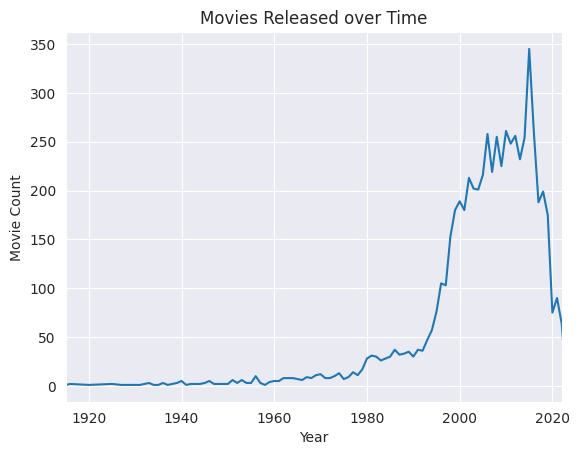

In [ ]:
with sns.axes_style('darkgrid'):
  ax = sns.lineplot(data=films_per_year)

  # excluded 2023 since the data was scraped well before the end of the year
  ax.set(xlim=[films_per_year.index.min(), films_per_year.index.max()-1],
         title='Movies Released over Time',
         xlabel='Year',
         ylabel='Movie Count')

The big dip in film releases in the 2020s is most likely due to COVID restrictions.

### Plotting Budget and Profit Over Time

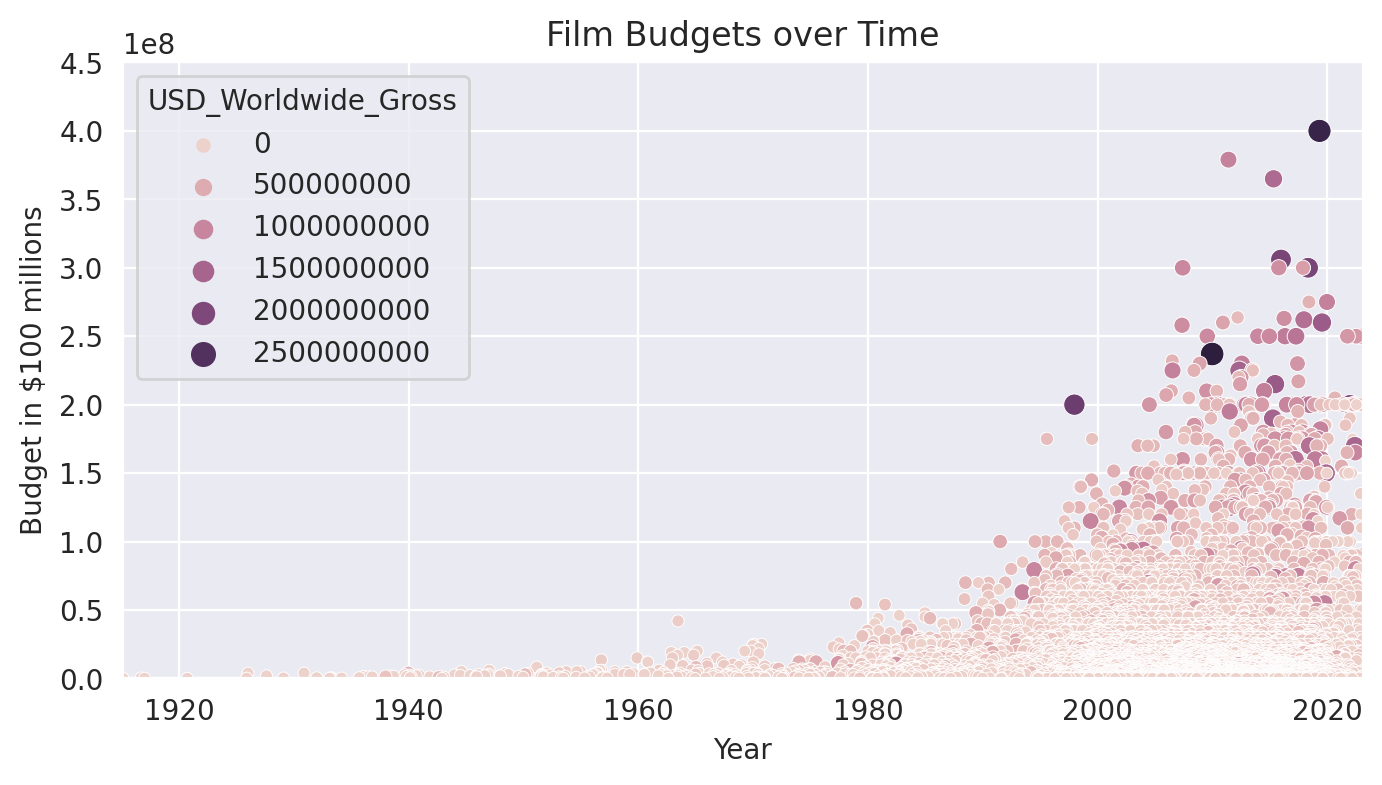

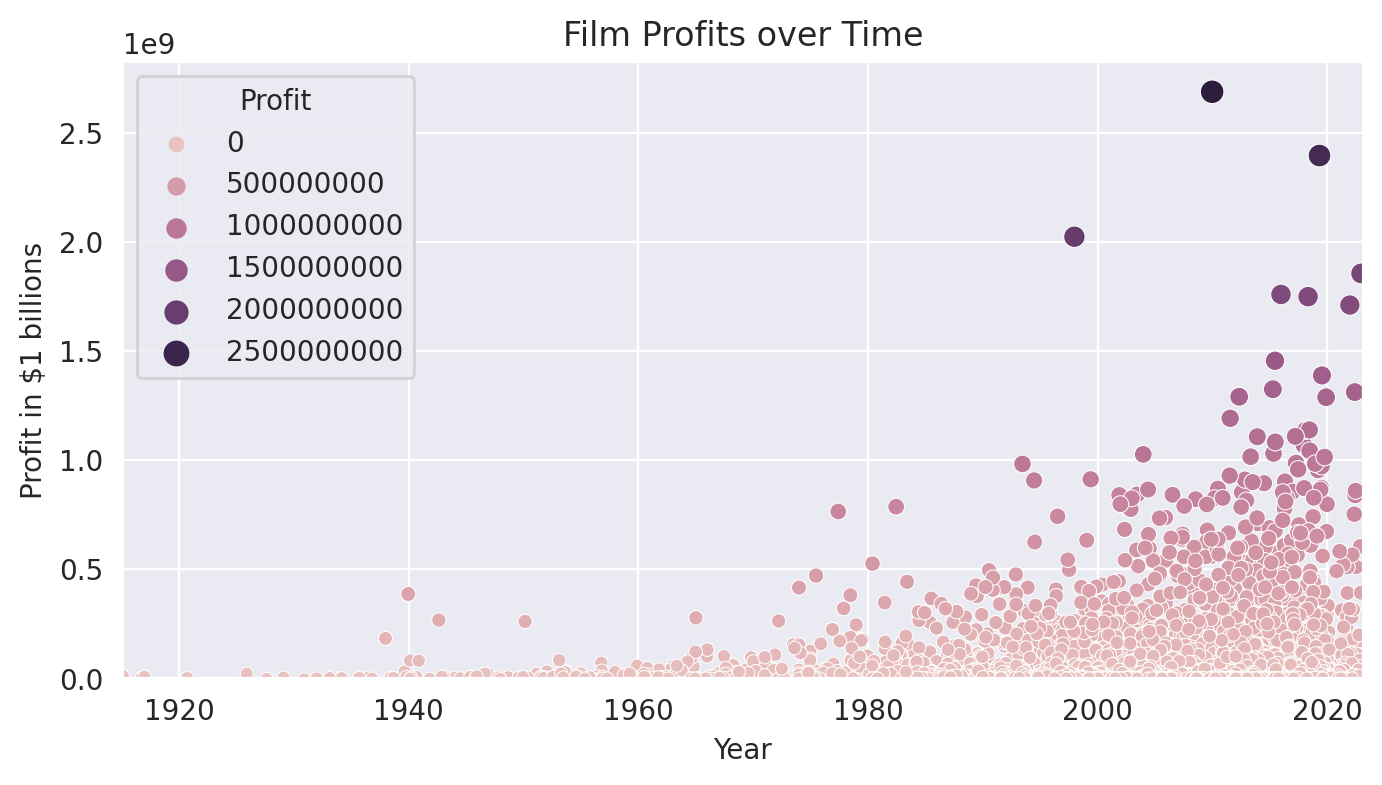

In [ ]:
plt.figure(figsize=(8,4), dpi=200)

# set styling on single chart
with sns.axes_style('darkgrid'):
  ax = sns.scatterplot(data=data_clean,
                       x='Release_Date',
                       y='USD_Production_Budget',
                       hue='USD_Worldwide_Gross',
                       size='USD_Worldwide_Gross')
  
  ax.set(ylim=[0.0, 4.5e8],
         xlim=[data_clean.Release_Date.min(), data_clean.Release_Date.max()],
         ylabel='Budget in $100 millions',
         xlabel='Year',
         title='Film Budgets over Time')
  

plt.figure(figsize=(8,4), dpi=200)

with sns.axes_style('darkgrid'):
  ax = sns.scatterplot(data=data_clean,
                       x='Release_Date',
                       y='Profit',
                       hue='Profit',
                       size='Profit')
  
  ax.set(ylim=[0.0, data_clean.Profit.max()*1.05],
         xlim=[data_clean.Release_Date.min(), data_clean.Release_Date.max()],
         ylabel='Profit in $1 billions',
         xlabel='Year',
         title='Film Profits over Time')

### Plotting Rolling Averages of Yearly Mean and Median Budgets and Profits

In [ ]:
rolling_avg = data_clean.loc[:, ['USD_Production_Budget', 'Profit']]
rolling_avg['Year'] = data_clean.Release_Date.dt.year

rolling_med = data_clean.loc[:, ['USD_Production_Budget', 'Profit']]
rolling_med['Year'] = data_clean.Release_Date.dt.year
rolling_med = rolling_med.rename(columns={'USD_Production_Budget': 'Med_Budget', 
                                          'Profit': 'Med_Profit'})

In [ ]:
rolling_avg = rolling_avg.groupby('Year')[['USD_Production_Budget', 'Profit']].mean()
rolling_med = rolling_med.groupby('Year')[['Med_Budget', 'Med_Profit']].median()

In [ ]:
window = 6
rolling_avg['Rolling_Budget'] = rolling_avg.loc[:, 'USD_Production_Budget'].rolling(window=window).mean()
rolling_avg['Rolling_Profit'] = rolling_avg.loc[:, 'Profit'].rolling(window=window).mean()

rolling_med['Rolling_Med_Budget'] = rolling_med.loc[:, 'Med_Budget'].rolling(window=window).mean()
rolling_med['Rolling_Med_Profit'] = rolling_med.loc[:, 'Med_Profit'].rolling(window=window).mean()

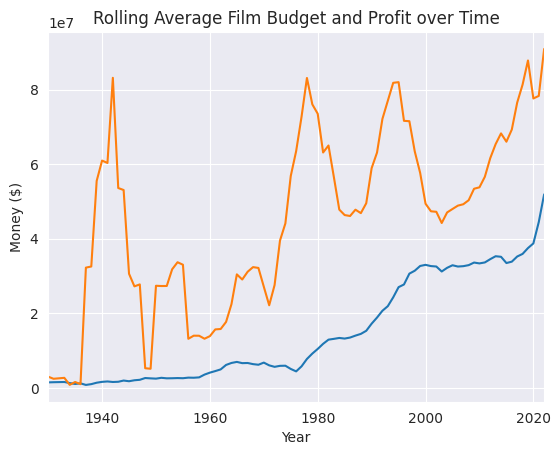

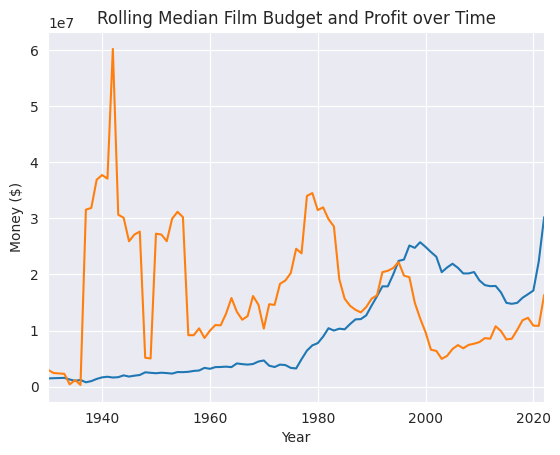

In [ ]:
with sns.axes_style('darkgrid'):
  ax = sns.lineplot(data=rolling_avg,
                    x='Year',
                    y='Rolling_Budget')
  
  ax2 = sns.lineplot(data=rolling_avg,
                     x='Year',
                     y='Rolling_Profit')
  
  # rolling window shifts valid rolling values
  ax2.set(xlim=[rolling_avg.index[window], rolling_avg.index.max()-1],
          xlabel='Year',
          ylabel='Money ($)',
          title='Rolling Average Film Budget and Profit over Time')
  
  plt.show()

with sns.axes_style('darkgrid'):
  ax = sns.lineplot(data=rolling_med,
                    x='Year',
                    y='Rolling_Med_Budget')
  
  ax2 = sns.lineplot(data=rolling_med,
                     x='Year',
                     y='Rolling_Med_Profit')
  
  ax2.set(xlim=[rolling_med.index[window], rolling_med.index.max()-1],
          xlabel='Year',
          ylabel='Money ($)',
          title='Rolling Median Film Budget and Profit over Time')
  
  plt.show()

WIth a rolling window of 6

### Separate the "old" (before 1969) and "New" (1970s onwards) Films

**Challenge**: Create two new DataFrames: `old_films` and `new_films`
* `old_films` should include all the films before 1969 (up to and including 1969)
* `new_films` should include all the films from 1970 onwards
* How many films were released prior to 1970?
* What was the most expensive film made prior to 1970?

In [ ]:
old_films = data_clean[data_clean.Release_Date.dt.year < 1970]
new_films = data_clean[data_clean.Release_Date.dt.year >= 1970]

In [ ]:
old_films.describe()

,USD_Production_Budget,USD_Domestic_Gross,USD_Worldwide_Gross,Profit
count,166.00,166.00,166.00,166.00
mean,"4,364,377.03","21,575,645.01","29,031,045.13","24,666,668.10"
std,"5,556,954.68","32,338,867.47","53,490,075.97","52,741,879.15"
min,"60,000.00",0.00,0.00,"-14,250,000.00"
25%,"1,212,500.00","3,550,000.00","4,000,000.00","1,189,250.00"
50%,"2,673,000.00","9,425,000.00","9,425,000.00","7,086,000.00"
75%,"5,000,000.00","27,400,000.00","31,384,083.50","24,712,500.00"
max,"42,000,000.00","198,680,470.00","390,525,192.00","386,625,192.00"


In [ ]:
old_films.sort_values('USD_Production_Budget', ascending=False).head()

,Rank,Release_Date,Movie_Title,USD_Production_Budget,USD_Domestic_Gross,USD_Worldwide_Gross,Profit
1503,"1,504",1963-06-12,Cleopatra,"42,000,000.00","57,000,000.00","71,000,000.00","29,000,000.00"
2575,"2,576",1969-12-16,"Hello, Dolly","24,000,000.00","33,208,099.00","33,208,099.00","9,208,099.00"
2815,"2,816",1969-10-15,Paint Your Wagon,"20,000,000.00","31,678,778.00","31,678,778.00","11,678,778.00"
2871,"2,872",1965-02-15,The Greatest Story Ever Told,"20,000,000.00","15,473,333.00","15,473,333.00","-4,526,667.00"
2913,"2,914",1969-04-01,Sweet Charity,"20,000,000.00","8,000,000.00","8,000,000.00","-12,000,000.00"


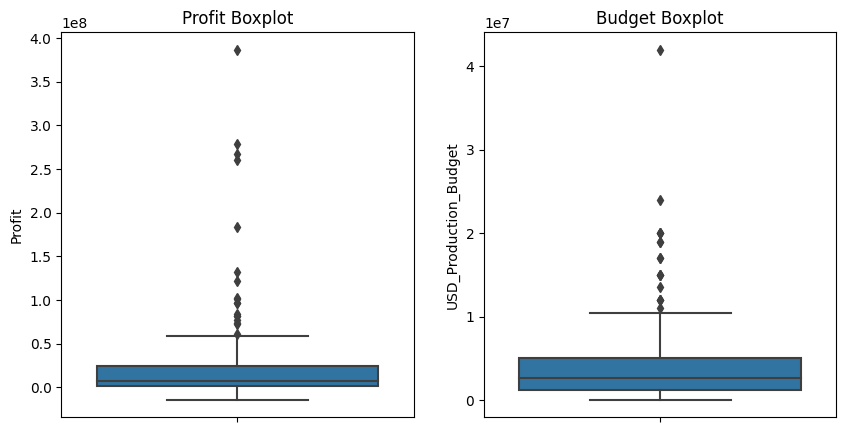

In [ ]:
# Create two subplots, one for each boxplot
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(8,16))

# Plot the boxplot for Profit in the first subplot
sns.boxplot(y='Profit', data=old_films, ax=ax1)
ax1.set_title('Profit Boxplot')

# Plot the boxplot for Budget in the second subplot
sns.boxplot(y='USD_Production_Budget', data=old_films, ax=ax2)
ax2.set_title('Budget Boxplot')

# Show the plots
plt.show()

# Linear Regression Plots Between Worldwide Revenue and Budgets

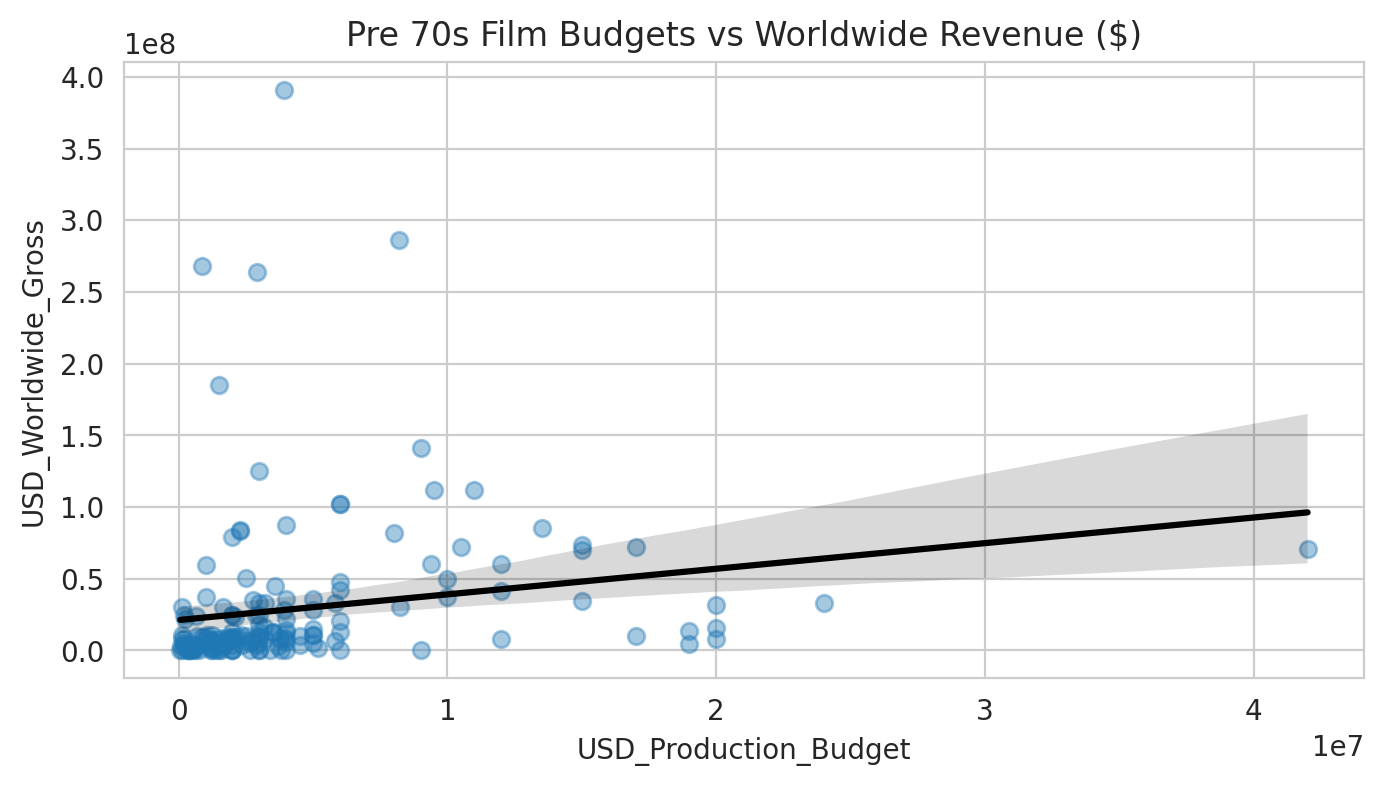

In [ ]:
plt.figure(figsize=(8,4), dpi=200)
with sns.axes_style('whitegrid'):
  ax = sns.regplot(data=old_films,
              x='USD_Production_Budget',
              y='USD_Worldwide_Gross',
              scatter_kws={'alpha': 0.4},
              line_kws={'color': 'black'},)
  
  ax.set(title='Pre 70s Film Budgets vs Worldwide Revenue ($)')

Interpret the chart

* Do our data points for the new films align better or worse with the linear regression than for our older films?
* Roughly how much would a film with a budget of $150 million make according to the regression line?

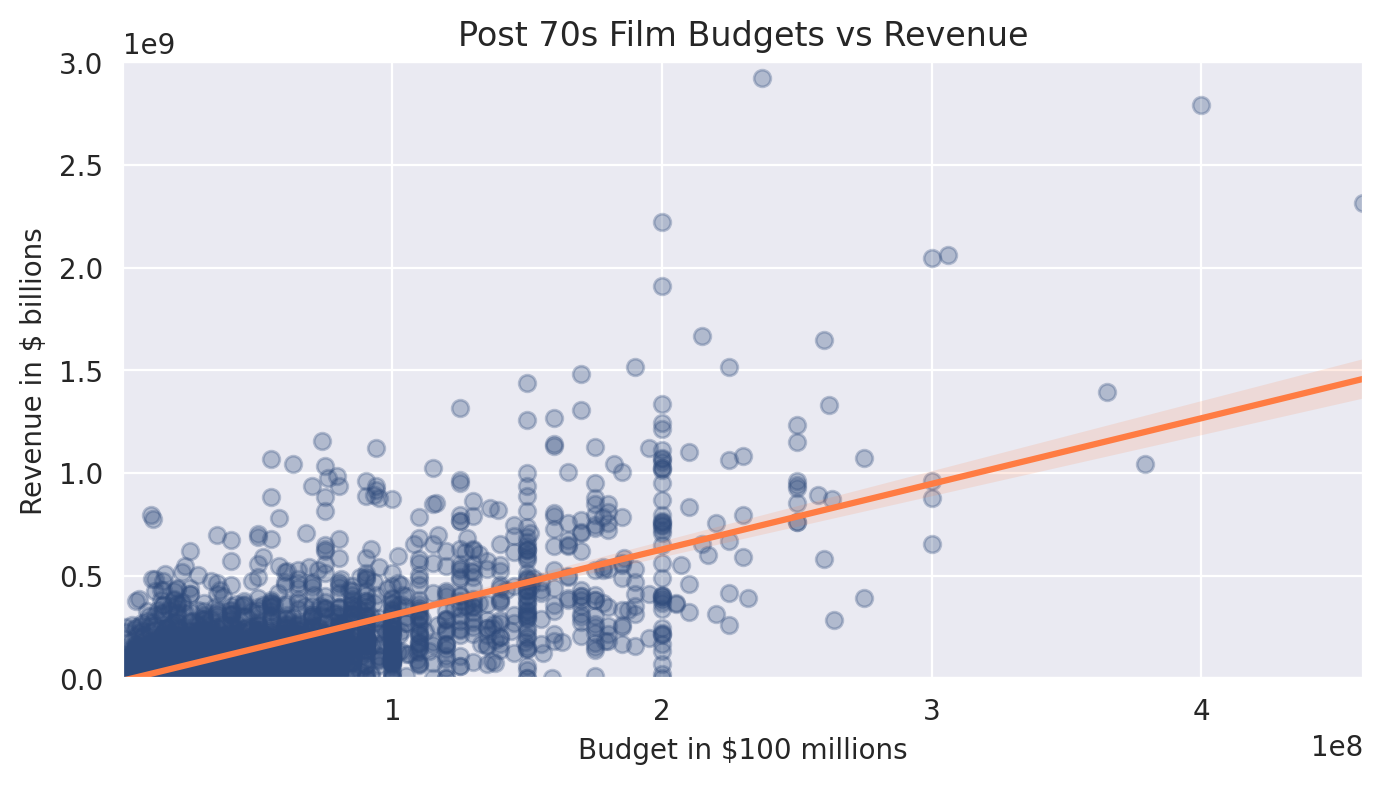

In [ ]:
plt.figure(figsize=(8,4), dpi=200)
with sns.axes_style('darkgrid'):
  ax = sns.regplot(data=new_films,
              x='USD_Production_Budget',
              y='USD_Worldwide_Gross',
              color= '#2f4b7c',
              scatter_kws={'alpha': 0.3},
              line_kws={'color': '#ff7c43'})
 
  ax.set(xlim=[new_films.USD_Production_Budget.min(), new_films.USD_Production_Budget.max()],
         ylim=[0, 3e9],
         xlabel='Budget in $100 millions',
         ylabel='Revenue in $ billions',
         title='Post 70s Film Budgets vs Revenue')

# Linear Regression between Production Budget and Worldwide Gross Revenue

$$ REV \hat ENUE = \theta _0 + \theta _1 BUDGET$$

**Challenge**: Run a linear regression for the `old_films`. Calculate the intercept, slope and r-squared. How much of the variance in movie revenue does the linear model explain in this case?

In [ ]:
regression = LinearRegression()
regression_old = LinearRegression()

LinearRegression does not like Pandas Series. So we feed them dataframes.

In [ ]:
# Explanatory Variables(s) or Feature(s)
X = pd.DataFrame(new_films, columns=['USD_Production_Budget'])
X_old = pd.DataFrame(old_films, columns=['USD_Production_Budget'])

# Reponse Variable or Target
y = pd.DataFrame(new_films, columns=['USD_Worldwide_Gross'])
y_old = pd.DataFrame(old_films, columns=['USD_Worldwide_Gross'])

In [ ]:
regression.fit(X, y)
regression_old.fit(X_old, y_old)

LinearRegression()

WIP: add correlation coeff info (R)

In [ ]:
# intercept and coef member variables are contained within arrays, hence the indexing
print(f'REVENUE_OLD = {regression_old.intercept_[0]:.2f} + {regression_old.coef_[0][0]:.2f}BUDGET') 
print(f'With an R-squared of: {regression_old.score(X_old, y_old):.4f}')

REVENUE_OLD = 21232048.49 + 1.79BUDGET
With an R-squared of: 0.0345


In [ ]:
print(f'REVENUE_NEW = {regression.intercept_[0]:.2f} + {regression.coef_[0][0]:.2f}BUDGET') 
print(f'With an R-squared of: {regression.score(X, y):.4f}')

REVENUE_NEW = -10444177.17 + 3.19BUDGET
With an R-squared of: 0.5477


With an R-squared close to zero, the regression model for pre-70s films should not be taken into consideration. 

# Use Your Model to Make a Prediction

We just estimated the slope and intercept! Remember that our Linear Model has the following form:

$$ REV \hat ENUE = \theta _0 + \theta _1 BUDGET$$

In [ ]:
new_film_estimate = (regression.intercept_ + regression.coef_*350e6)[0][0]
old_film_estimate = (regression_old.intercept_ + regression_old.coef_*350e6)[0][0]

In [ ]:
print(f'New Film Revenue for $350mil: {new_film_estimate:.10}')
print(f'Old Film Revenue for $350mil: {old_film_estimate:.10}')

New Film Revenue for $350mil: 1.107321568e+09
Old Film Revenue for $350mil: 646670411.5


Add plot showing an optimal budget range to revenue range for recommendations.